## Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import isnan
from matplotlib import cm
import glob
from IPython.display import clear_output
import numpy.polynomial.polynomial as poly

%matplotlib inline
pd.options.display.max_columns = 999
gr      = 1.618

# dead wires
z_dead_start = 675
z_dead_end=z_dead_start+100
flux_corr = 1.028

In [2]:
# Main dataframe
columns= [ # True
          "run", "subrun", "event",
          "bnbweight",
          "true_1eX_signal","nu_E",
          "nu_daughters_pdg","nu_daughters_E",
          "true_vx","true_vy","true_vz",
           # Reco
          "category", "n_primaries",
          "shower_energy_hits",
          "shower_energy_cali",
          "shower_energy_product",
    
          "matched_tracks", "matched_showers",
          "matched_tracks_energy", "matched_showers_energy",
          "shower_fidvol_ratio",
          
          "shower_hits_w",
          "shower_energy_w"
         ]

## Shower Energy Calibration

In [3]:
inputlist = []
#inputlist += glob.glob("/home/wouter/Templates/May/bnb_nu_cosmic_0s0t_dev/*.root")
inputlist += glob.glob("/home/wouter/Templates/May/bnb_nu_cosmic_0s0t_dev/*.root")
print(len(inputlist))

sample="nu"

278


In [4]:
if 0:
    from root_pandas import read_root
    chunks = []
    
    for i_f,fname in enumerate(inputlist):
        clear_output(wait=True)
        print (i_f)
        dftemp=read_root(fname,"wouterNueCC/pandoratree",columns=columns)  
        chunks.append(dftemp)
    
    clear_output(wait=True)
    print ("Done loading, start processing df")
        
    df = pd.concat(chunks,ignore_index=True,copy=False) 
    df["true_z_deadwire"] = ~df['true_vz'].between(z_dead_start,z_dead_end)
    df["bnbweight"]*=flux_corr
    df.to_pickle("./input/df_"+sample+"_shower_E.pckl")

else:
    df_nue = pd.read_pickle("./input/df_nue_shower_E.pckl")

In [5]:
electron_E_0 = []
electron_E_1 = []
electron_E_2 = []

electron_cali_0 = []
electron_cali_1 = []
electron_cali_2 = []

electron_prod_0 = []
electron_prod_1 = []
electron_prod_2 = []

true_electron_E = []
event_weight = []

df = df_nue.query("true_1eX_signal==1 & true_z_deadwire==1 & category==2")

for index, row in df.iterrows():     
    if 11 not in row["matched_tracks"] and sum(row["matched_showers"]==11)==1:
        index = np.argmax(row["matched_showers"]==11)
        
        electron_E_0.append( row["shower_energy_hits"][index][0] )
        electron_E_1.append( row["shower_energy_hits"][index][1] )
        electron_E_2.append( row["shower_energy_hits"][index][2] )
        
        electron_cali_0.append( row["shower_energy_cali"][index][0] )
        electron_cali_1.append( row["shower_energy_cali"][index][1] )
        electron_cali_2.append( row["shower_energy_cali"][index][2] )
          
        electron_prod_0.append( row["shower_energy_product"][index][0] )
        electron_prod_1.append( row["shower_energy_product"][index][1] )
        electron_prod_2.append( row["shower_energy_product"][index][2] )

        true_electron_E.append( row["matched_showers_energy"][index] )
        event_weight.append( row["bnbweight"])

14990


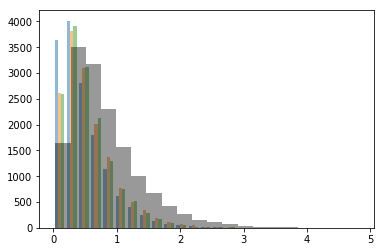

In [42]:
plt.hist([electron_E_0,electron_E_1,electron_E_2],bins=20,alpha=0.5)
plt.hist(true_electron_E,alpha=0.4,color="k", bins=20)
print(len(electron_E_0))

electron_Ecali_0 = np.array(electron_E_0)*np.array(electron_cali_0)
electron_Ecali_1 = np.array(electron_E_1)*np.array(electron_cali_1)
electron_Ecali_2 = np.array(electron_E_2)*np.array(electron_cali_2)

electron_prod_0 = [x if x>0 else 0.0 for x in electron_prod_0 ]
electron_prod_1 = [x if x>0 else 0.0 for x in electron_prod_1 ]
electron_prod_2 = [x if x>0 else 0.0 for x in electron_prod_2 ]

[472.64184354]
[468.8302551]
[515.45063305]


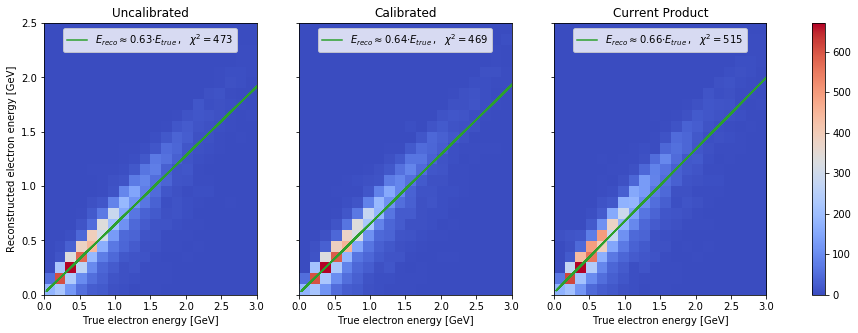

In [58]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(10*gr,5),sharey=True,sharex=True)

counts, xedges, yedges, im0 = ax[0].hist2d(true_electron_E,electron_E_2,
                                          bins=(20,25),range=([0,3],[0,2.5]),weights=event_weight,cmap=cm.coolwarm)


coefs, [residuals, rank, singular_values, rcond] = poly.polyfit(true_electron_E, electron_E_2, 1, full=True)
print(residuals)
ffit = poly.polyval(true_electron_E, coefs)
ax[0].plot(true_electron_E, ffit, label=r"$E_{reco} \approx$"+'{0:.2f}'.format(coefs[1])+"$\cdot E_{true} \:, \:\:\: \chi^2 = $"+'{0:.0f}'.format(residuals[0]),color="C2")
ax[0].legend(loc="upper center")

counts, xedges, yedges, im1 = ax[1].hist2d(true_electron_E,electron_Ecali_2,
                                          bins=(20,25),range=([0,3],[0,2.5]),weights=event_weight,cmap=cm.coolwarm)

coefs, [residuals, rank, singular_values, rcond] = poly.polyfit(true_electron_E, electron_Ecali_2, 1, full=True)
print(residuals)
ffit = poly.polyval(true_electron_E, coefs)
ax[1].plot(true_electron_E, ffit, label=r"$E_{reco} \approx$"+'{0:.2f}'.format(coefs[1])+"$\cdot E_{true} \:, \:\:\: \chi^2 = $"+'{0:.0f}'.format(residuals[0]),color="C2")
ax[1].legend(loc="upper center")

counts, xedges, yedges, im1 = ax[2].hist2d(true_electron_E,electron_prod_2,
                                          bins=(20,25),range=([0,3],[0,2.5]),weights=event_weight,cmap=cm.coolwarm)

coefs, [residuals, rank, singular_values, rcond] = poly.polyfit(true_electron_E, electron_prod_2, 1, full=True)
ffit = poly.polyval(true_electron_E, coefs)
print(residuals)
ax[2].plot(true_electron_E, ffit, label=r"$E_{reco} \approx$"+'{0:.2f}'.format(coefs[1])+"$\cdot E_{true} \:, \:\:\: \chi^2 = $"+'{0:.0f}'.format(residuals[0]),color="C2")
ax[2].legend(loc="upper center")

plt.colorbar(im1, ax=ax)

ax[0].set_title('Uncalibrated')
ax[1].set_title('Calibrated')
ax[2].set_title('Current Product')

ax[0].set_xlabel('True electron energy [GeV]')
ax[1].set_xlabel('True electron energy [GeV]')
ax[2].set_xlabel('True electron energy [GeV]')
ax[0].set_ylabel('Reconstructed electron energy [GeV]')

plt.savefig("../../Output/cali2d_plane2.pdf",bbox_inches='tight', pad_inches=0.1)

[609.73759793]
[613.42353352]
[667.91184653]


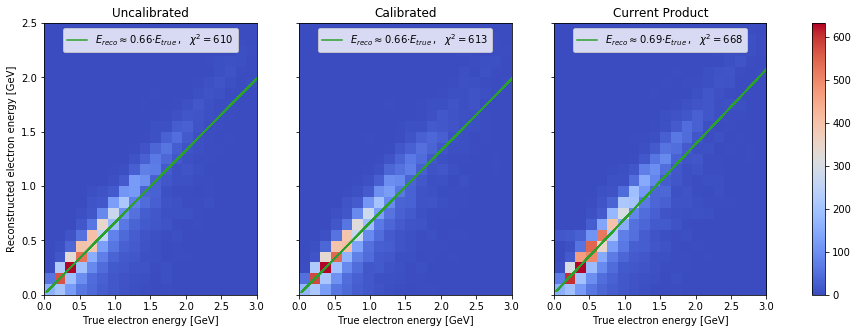

In [50]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(10*gr,5),sharey=True,sharex=True)

counts, xedges, yedges, im0 = ax[0].hist2d(true_electron_E,electron_E_1,
                                          bins=(20,25),range=([0,3],[0,2.5]),weights=event_weight,cmap=cm.coolwarm)


coefs, [residuals, rank, singular_values, rcond] = poly.polyfit(true_electron_E, electron_E_1, 1, full=True)
print(residuals)
ffit = poly.polyval(true_electron_E, coefs)
ax[0].plot(true_electron_E, ffit, label=r"$E_{reco} \approx$"+'{0:.2f}'.format(coefs[1])+"$\cdot E_{true} \:, \:\:\: \chi^2 = $"+'{0:.0f}'.format(residuals[0]),color="C2")
ax[0].legend(loc="upper center")

counts, xedges, yedges, im1 = ax[1].hist2d(true_electron_E,electron_Ecali_1,
                                          bins=(20,25),range=([0,3],[0,2.5]),weights=event_weight,cmap=cm.coolwarm)

coefs, [residuals, rank, singular_values, rcond] = poly.polyfit(true_electron_E, electron_Ecali_1, 1, full=True)
print(residuals)
ffit = poly.polyval(true_electron_E, coefs)
ax[1].plot(true_electron_E, ffit, label=r"$E_{reco} \approx$"+'{0:.2f}'.format(coefs[1])+"$\cdot E_{true} \:, \:\:\: \chi^2 = $"+'{0:.0f}'.format(residuals[0]),color="C2")
ax[1].legend(loc="upper center")

counts, xedges, yedges, im1 = ax[2].hist2d(true_electron_E,electron_prod_1,
                                          bins=(20,25),range=([0,3],[0,2.5]),weights=event_weight,cmap=cm.coolwarm)

coefs, [residuals, rank, singular_values, rcond] = poly.polyfit(true_electron_E, electron_prod_1, 1, full=True)
ffit = poly.polyval(true_electron_E, coefs)
print(residuals)
ax[2].plot(true_electron_E, ffit, label=r"$E_{reco} \approx$"+'{0:.2f}'.format(coefs[1])+"$\cdot E_{true} \:, \:\:\: \chi^2 = $"+'{0:.0f}'.format(residuals[0]),color="C2")
ax[2].legend(loc="upper center")

plt.colorbar(im1, ax=ax)

ax[0].set_title('Uncalibrated')
ax[1].set_title('Calibrated')
ax[2].set_title('Current Product')

ax[0].set_xlabel('True electron energy [GeV]')
ax[1].set_xlabel('True electron energy [GeV]')
ax[2].set_xlabel('True electron energy [GeV]')
ax[0].set_ylabel('Reconstructed electron energy [GeV]')

plt.savefig("../../Output/cali2d_plane1.pdf",bbox_inches='tight', pad_inches=0.1)

[760.05385425]
[766.60042381]
[868.45163708]


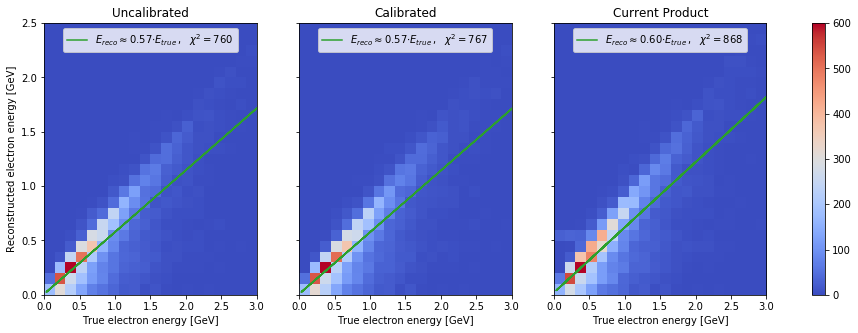

In [51]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(10*gr,5),sharey=True,sharex=True)

counts, xedges, yedges, im0 = ax[0].hist2d(true_electron_E,electron_E_0,
                                          bins=(20,25),range=([0,3],[0,2.5]),weights=event_weight,cmap=cm.coolwarm)


coefs, [residuals, rank, singular_values, rcond] = poly.polyfit(true_electron_E, electron_E_0, 1, full=True)
print(residuals)
ffit = poly.polyval(true_electron_E, coefs)
ax[0].plot(true_electron_E, ffit, label=r"$E_{reco} \approx$"+'{0:.2f}'.format(coefs[1])+"$\cdot E_{true} \:, \:\:\: \chi^2 = $"+'{0:.0f}'.format(residuals[0]),color="C2")
ax[0].legend(loc="upper center")

counts, xedges, yedges, im1 = ax[1].hist2d(true_electron_E,electron_Ecali_0,
                                          bins=(20,25),range=([0,3],[0,2.5]),weights=event_weight,cmap=cm.coolwarm)

coefs, [residuals, rank, singular_values, rcond] = poly.polyfit(true_electron_E, electron_Ecali_0, 1, full=True)
print(residuals)
ffit = poly.polyval(true_electron_E, coefs)
ax[1].plot(true_electron_E, ffit, label=r"$E_{reco} \approx$"+'{0:.2f}'.format(coefs[1])+"$\cdot E_{true} \:, \:\:\: \chi^2 = $"+'{0:.0f}'.format(residuals[0]),color="C2")
ax[1].legend(loc="upper center")

counts, xedges, yedges, im1 = ax[2].hist2d(true_electron_E,electron_prod_0,
                                          bins=(20,25),range=([0,3],[0,2.5]),weights=event_weight,cmap=cm.coolwarm)

coefs, [residuals, rank, singular_values, rcond] = poly.polyfit(true_electron_E, electron_prod_0, 1, full=True)
ffit = poly.polyval(true_electron_E, coefs)
print(residuals)
ax[2].plot(true_electron_E, ffit, label=r"$E_{reco} \approx$"+'{0:.2f}'.format(coefs[1])+"$\cdot E_{true} \:, \:\:\: \chi^2 = $"+'{0:.0f}'.format(residuals[0]),color="C2")
ax[2].legend(loc="upper center")

plt.colorbar(im1, ax=ax)

ax[0].set_title('Uncalibrated')
ax[1].set_title('Calibrated')
ax[2].set_title('Current Product')

ax[0].set_xlabel('True electron energy [GeV]')
ax[1].set_xlabel('True electron energy [GeV]')
ax[2].set_xlabel('True electron energy [GeV]')
ax[0].set_ylabel('Reconstructed electron energy [GeV]')

plt.savefig("../../Output/cali2d_plane0.pdf",bbox_inches='tight', pad_inches=0.1)

In [2]:
fname_nue = '../../Input/dev_set/nue/nue_0.pckl'
fname_nu  = '../../Input/dev_set/nu/nu_0.pckl'

In [10]:
def MatchedElectronEnergy(row):
    reco_matched_lepton_E = 0
    reco_matched_lepton_E_cali = 0
    
    for pdg,E,cali in zip(*row[['matched_showers','shower_energy','shower_cali']]):
        if pdg==11:
            reco_matched_lepton_E += E
            reco_matched_lepton_E_cali += E*(cali)
    for pdg,E,cali in zip(*row[['matched_tracks','track_energy','track_cali']]):
        if pdg==11:
            reco_matched_lepton_E += E
            reco_matched_lepton_E_cali += E*(cali)
            
    return pd.Series({"reco_matched_lepton_E":reco_matched_lepton_E, "reco_matched_lepton_E_cali":reco_matched_lepton_E_cali})

def ClosestElectronDedx(row):
    if (11 not in row['matched_showers']) and (11 not in row['matched_tracks']):
        return pd.Series({'cl_e_dedx': 0, 'cl_e_dedx_cali': 0}) 
    
    cl_e_dedx=0
    cl_e_dedx_cali=0
    
    d=20 # If the closest object is further than 10cm, forget it anyway
    i = -1
    
    true_x = row["true_vx_sce"]
    true_y = row["true_vy_sce"]
    true_z = row["true_vz_sce"]
    
    if (11 in row['matched_showers']):
        sh_x_arr = row["shower_start_x"]
        sh_y_arr = row["shower_start_y"]
        sh_z_arr = row["shower_start_z"]
        sh_pdg_arr = row['matched_showers']
        sh_dedx_arr = row['shower_dedx']
        sh_dedx_avg_arr = row['shower_dedx_avg']
        sh_dedx_cali_arr = row['shower_dedx_cali']
    
        for sh_x,sh_y,sh_z,sh_pdg,sh_dedx,sh_dedx_avg,sh_dedx_cali in zip(sh_x_arr,sh_y_arr,sh_z_arr,sh_pdg_arr,sh_dedx_arr,sh_dedx_avg_arr,sh_dedx_cali_arr):
            if sh_pdg==11:
                dist = np.linalg.norm([sh_x-true_x,sh_y-true_y,sh_z-true_z])
                if dist<d:
                    d=dist
                    cl_e_dedx=sh_dedx_avg
                    cl_e_dedx_cali=sh_dedx*sh_dedx_cali
    
    if (11 in row['matched_tracks']):
        tr_x_arr = row["track_start_x"]
        tr_y_arr = row["track_start_y"]
        tr_z_arr = row["track_start_z"]
        tr_pdg_arr = row['matched_tracks']
        tr_dedx_arr = row['track_dedx']
        tr_dedx_avg_arr = row['track_dedx_avg']
        tr_dedx_cali_arr = row['track_dedx_cali']
    
        for tr_x,tr_y,tr_z,tr_pdg,tr_dedx, tr_dedx_avg, tr_dedx_cali in zip(tr_x_arr,tr_y_arr,tr_z_arr,tr_pdg_arr,tr_dedx_arr,tr_dedx_avg_arr,tr_dedx_cali_arr):
            if tr_pdg==11:
                dist = np.linalg.norm([tr_x-true_x,tr_y-true_y,tr_z-true_z])
                if dist<d:
                    d=dist
                    cl_e_dedx=tr_dedx_avg
                    cl_e_dedx_cali=tr_dedx*tr_dedx_cali
            
    return pd.Series({'cl_e_dedx': cl_e_dedx, 'cl_e_dedx_cali': cl_e_dedx_cali}) 

In [11]:
df = pd.read_pickle(fname)
print(df.columns)
df.head(5)

Index(['event', 'subrun', 'run', 'nu_pdg', 'nu_E', 'true_vx_sce',
       'true_vy_sce', 'true_vz_sce', 'distance', 'category', 'vx', 'vy', 'vz',
       'bnbweight', 'passed', 'shower_open_angle', 'shower_length',
       'shower_start_x', 'shower_start_y', 'shower_start_z', 'shower_dir_x',
       'shower_dir_y', 'shower_dir_z', 'shower_pca', 'track_start_x',
       'track_start_y', 'track_start_z', 'track_end_x', 'track_end_y',
       'track_end_z', 'track_dir_x', 'track_dir_y', 'track_dir_z', 'track_pca',
       'predict_em', 'predict_mu', 'predict_cos', 'predict_pi', 'predict_p',
       'nu_daughters_pdg', 'nu_daughters_E', 'nu_daughters_px',
       'nu_daughters_py', 'nu_daughters_pz', 'nu_daughters_endx',
       'nu_daughters_endy', 'nu_daughters_endz', 'true_shower_pdg',
       'true_shower_x_sce', 'true_shower_y_sce', 'true_shower_z_sce',
       'true_shower_depE', 'shower_daughter', 'shower_is_daughter',
       'track_daughter', 'track_is_daughter', 'shower_containment_q',
      

,event,subrun,run,nu_pdg,nu_E,true_vx_sce,true_vy_sce,true_vz_sce,distance,category,vx,vy,vz,bnbweight,passed,shower_open_angle,shower_length,shower_start_x,shower_start_y,shower_start_z,shower_dir_x,shower_dir_y,shower_dir_z,shower_pca,track_start_x,track_start_y,track_start_z,track_end_x,track_end_y,track_end_z,track_dir_x,track_dir_y,track_dir_z,track_pca,predict_em,predict_mu,predict_cos,predict_pi,predict_p,nu_daughters_pdg,nu_daughters_E,nu_daughters_px,nu_daughters_py,nu_daughters_pz,nu_daughters_endx,nu_daughters_endy,nu_daughters_endz,true_shower_pdg,true_shower_x_sce,true_shower_y_sce,true_shower_z_sce,true_shower_depE,shower_daughter,shower_is_daughter,track_daughter,track_is_daughter,shower_containment_q,shower_sp_profile,reconstructed_energy,shower_energy,shower_nhits,total_nhits,track_energy,track_nhits,shower_dedx,shower_dedx_avg,shower_dedx_hits,track_dedx,track_dedx_avg,track_dedx_hits,flash_PE,flash_time,CC_daughter_E,true_shower_endx,true_shower_endy,true_shower_endz,true_shower_tmax_x,true_shower_tmax_y,true_shower_tmax_z,matched_showers,matched_showers_energy,matched_tracks,matched_tracks_energy
0,338111,6763,1,12,4.995859,189.162140,53.705956,766.479065,0.675555,2,188.996567,54.360748,766.464539,0.433257,1,"[0.034302, 0.55664, 0.18298, 0.068726, 0.15186...","[196.5, 51.125, 81.375, 151.5, 30.828, 30.984,...","[188.38, 194.0, 189.38, 200.75, 202.75, 173.0,...","[53.625, 56.406, 62.5, 59.875, 49.281, 16.734,...","[767.5, 811.5, 775.0, 784.5, 813.5, 832.0, 767...","[-0.5835, -0.17981, -0.31567, 0.46753, 0.4458,...","[-0.056671, 0.43042, 0.63232, 0.29346, -0.8950...","[0.81006, 0.88477, -0.70752, 0.83398, -0.01274...","[0.97754, 0.82959, 0.89404, 0.95996, 0.95898, ...",[194.62],[41.688],[798.5],[215.25],[104.94],[961.0],[-0.098999],[0.32788],[0.93945],[0.99609],[0.014389],[0.46655],[0.40259],[0.072449],[0.043945],"[11, 2112, 111, 2212, 211, 2112, 2112, 311, -311]","[0.83154, 1.4023, 0.36377, 0.94678, 0.52881, 1...","[-0.48511, 0.20032, 0.063354, -0.071106, 0.082...","[-0.058044, 0.020462, 0.058807, -0.044891, 0.1...","[0.67285, 1.0215, 0.32666, -0.095825, 0.48975,...","[185.5, 185.5, 185.5, 185.5, 185.5, 185.5, 185...","[58.719, 58.719, 58.719, 58.719, 58.719, 58.71...","[766.5, 766.5, 766.5, 766.5, 766.5, 766.5, 766...",[11],[189.12],[53.719],[766.5],[830.0],"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]",[0],[0],1.000000,1.544643,1.856288,"[0.496978698152, 0.131166932515, 0.31667734767...","[398.0, 117.0, 279.0, 129.0, 52.0, 38.0, 54.0,...",4194,[0.491198004233],[561.0],"[1.86524564087, 2.42362863723, 3.35934330505, ...","[2.59143324366, 4.07240914431, 4.33921970822, ...","[12.0, 15.0, 11.0, 12.0, 3.0, 6.0, 15.0, 6.0, ...",[1.44614341082],[4.35717751121],[3.0],5003.657227,4.17125,0.831447,78.385201,45.886101,915.114258,167.929108,56.599800,790.953674,"[11, 211, 211, 22, 211, 211, 22, 22, 22]","[0.831446934981, 0.528634357768, 0.50508131559...",[-211],[0.913227375941]
1,338116,6763,1,12,1.629150,103.200180,92.750435,488.355591,16.620516,2,103.934402,92.892776,504.959259,0.703084,1,[0.096497],[142.62],[104.94],[93.125],[505.0],[0.095093],[-0.54346],[0.83398],[0.89502],[104.0],[86.312],[501.25],[103.19],[78.938],[487.5],[-0.065125],[-0.38989],[-0.91846],[0.98193],[0.014778],[0.24854],[0.0023155],[0.64941],[0.085144],"[11, 2212, 2212, 2212, 2212, 2212, 2112, 2112,...","[1.2334, 0.98828, 0.94727, 0.95215, 0.96289, 1...","[0.10101, -0.094421, 0.019531, -0.16028, 0.214...","[-0.59961, 0.29443, -0.069885, -0.017853, -0.0...","[1.0732, -0.0186, 0.10785, 0.016525, 0.020035,...","[101.38, 101.38, 101.38, 101.38, 101.38, 101.3...","[96.125, 96.125, 96.125, 96.125, 96.125, 96.12...","[488.25, 488.25, 488.25, 488.25, 488.25, 488.2...",[11],[103.19],[92.75],[488.25],[1231.0],[0],[0],[0],[0],1.000000,1.245421,1.064689,[0.905611035834],[679.0],1733,[0.159078301026],[74.0],[7.17979765054],[101.692120364],[15.0],[2.071164404],[15.3911860296],[5.0],4480.976562,4.14125,1.233172,116.832542,4.211959,652.778748,104.264

In [12]:
df['category'].value_counts()/len(df.index)
#df["category"].hist()


2    0.725868
7    0.241419
1    0.032714
Name: category, dtype: float64

4.7981248

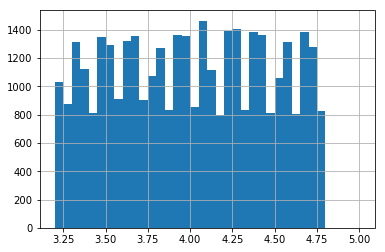

In [8]:
df[df['category']>-1]['flash_time'].hist(bins=36,range=(3.2,5.0))
min(df[df['category']>-1]['flash_time'])
max(df[df['category']>-1]['flash_time'])

In [7]:
df = pd.concat([df, df.apply(MatchedElectronEnergy,axis=1)], axis=1)

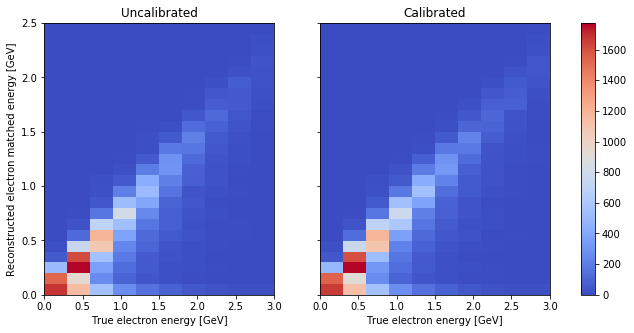

Bin start:0.0 	end:0.3 	median:0.11 	std:0.222 	median_cali:0.12 	std_cali:0.221
Bin start:0.3 	end:0.6 	median:0.27 	std:0.217 	median_cali:0.27 	std_cali:0.216
Bin start:0.6 	end:0.9 	median:0.48 	std:0.204 	median_cali:0.48 	std_cali:0.204
Bin start:0.9 	end:1.2 	median:0.68 	std:0.196 	median_cali:0.69 	std_cali:0.194
Bin start:1.2 	end:1.5 	median:0.88 	std:0.186 	median_cali:0.89 	std_cali:0.184
Bin start:1.5 	end:1.8 	median:1.09 	std:0.178 	median_cali:1.10 	std_cali:0.175
Bin start:1.8 	end:2.1 	median:1.31 	std:0.181 	median_cali:1.32 	std_cali:0.179
Bin start:2.1 	end:2.4 	median:1.52 	std:0.176 	median_cali:1.51 	std_cali:0.173
Bin start:2.4 	end:2.7 	median:1.72 	std:0.171 	median_cali:1.72 	std_cali:0.170
Bin start:2.7 	end:3.0 	median:1.95 	std:0.163 	median_cali:1.97 	std_cali:0.158


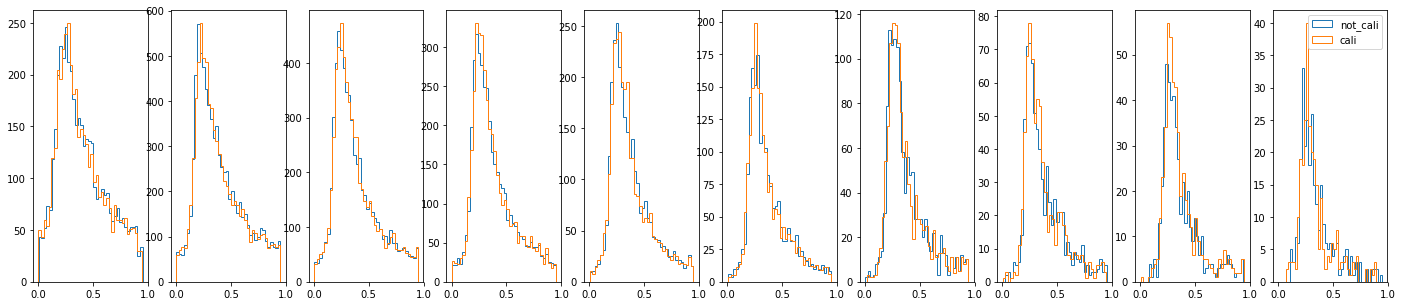

In [9]:
N = 10
fig,ax=plt.subplots(ncols=N,nrows=1,figsize=(15*gr,5),sharey=False,sharex=True)

for i in range(len(xedges)-1):
    indices = np.digitize(df['CC_daughter_E'],xedges[1:])
    
    missing = (df['CC_daughter_E'][indices==i]-df['reco_matched_lepton_E'][indices==i])/df['CC_daughter_E'][indices==i]
    missing = missing[(missing >= 0) & (missing <= .95)]
    ax[int(i)].hist(missing,bins=40,histtype='step',Fill=False,label='not_cali')
    median = np.median( df['reco_matched_lepton_E'][indices==i] )
    std = np.std( missing )
    
    missing = (df['CC_daughter_E'][indices==i]-df['reco_matched_lepton_E_cali'][indices==i])/df['CC_daughter_E'][indices==i]
    missing = missing[(missing >= 0) & (missing <= .95)]
    ax[int(i)].hist(missing,bins=40,histtype='step',Fill=False,label='cali')
    median_cali = np.median( df['reco_matched_lepton_E_cali'][indices==i] )
    std_cali = np.std( missing )
    
    print('Bin start:%.1f'%xedges[i],'\tend:%.1f'%xedges[i+1],'\tmedian:%.2f'%median,'\tstd:%.3f'%std,'\tmedian_cali:%.2f'%median_cali,'\tstd_cali:%.3f'%std_cali)

plt.legend()

In [14]:
df = pd.concat([df, df.apply(ClosestElectronDedx,axis=1)], axis=1)

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:45: RuntimeWarning: overflow encountered in double_scalars
/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in double_scalars


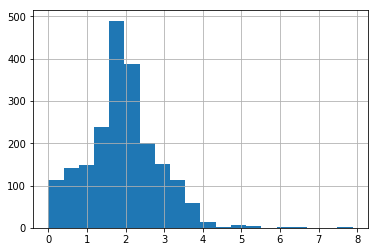

In [11]:
df[df['cl_g_dedx']>0]['cl_g_dedx'].hist(bins=20)

11.212389970326925
0.0
34765
25233


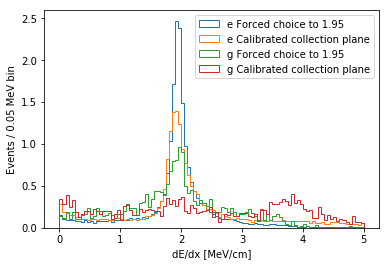

In [16]:
cl_e_dedx = df['cl_e_dedx']
cl_e_dedx_cali = df['cl_e_dedx_cali']
cl_g_dedx = df['cl_g_dedx']
cl_g_dedx_cali = df['cl_g_dedx_cali']
print(max(cl_e_dedx))
print(min(cl_e_dedx))
print(len(cl_e_dedx))
print(len(cl_e_dedx[cl_e_dedx>0]))

plt.hist(cl_e_dedx[cl_e_dedx>0],range=(0,5),bins=100,histtype='step',Fill=False,label='e Forced choice to 1.95',density=True)
plt.hist(cl_e_dedx_cali[cl_e_dedx_cali>0],range=(0,5),bins=100,histtype='step',Fill=False,label='e Calibrated collection plane',density=True)

plt.hist(cl_g_dedx[cl_g_dedx>0],range=(0,5),bins=100,histtype='step',Fill=False,label='g Forced choice to 1.95',density=True)
plt.hist(cl_g_dedx_cali[cl_g_dedx_cali>0],range=(0,5),bins=100,histtype='step',Fill=False,label='g Calibrated collection plane',density=True)
plt.legend()
plt.xlabel('dE/dx [MeV/cm]')
plt.ylabel('Events / 0.05 MeV bin')

plt.savefig("../Output/dedx_cali.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

## Try-outs with ROOT